In [111]:
import numpy as np
import numpy.typing as npt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# https://scikit-learn.org/stable/modules/cross_validation.html#stratification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

from math import ceil

from library.kernel_svm import SVM_SGA

In [98]:
df = pd.read_csv("dataset/parkinsons.csv")
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [99]:
df["status"].value_counts()

1    147
0     48
Name: status, dtype: int64

In [100]:
# up-sampling minority class
df_majority = df[df.status == 1]
df_minority = df[df.status == 0]

df_minority_upsampled = resample(
	df_minority,
	replace=True,
	n_samples=147, # match majority class
	random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled["status"].value_counts()

1    147
0    147
Name: status, dtype: int64

In [101]:
X = df_upsampled.drop(["status", "name"], axis=1)
y = df_upsampled["status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, shuffle = True, random_state = 42, stratify=y)

X_train

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
124,156.239,195.107,79.820,0.00694,0.00004,0.00403,0.00395,0.01209,0.02343,0.224,...,0.01720,0.03867,0.02020,19.196,0.618663,0.728421,-5.944191,0.143359,1.929715,0.181988
53,129.336,139.867,118.604,0.00490,0.00004,0.00165,0.00183,0.00495,0.02498,0.228,...,0.01947,0.04188,0.00484,25.429,0.420383,0.785714,-6.836811,0.269866,2.223719,0.147491
111,208.519,220.315,199.020,0.00609,0.00003,0.00368,0.00339,0.01105,0.01761,0.155,...,0.01307,0.02855,0.00830,22.407,0.338097,0.712466,-6.471427,0.184378,2.502336,0.136390
36,177.876,192.921,168.013,0.00411,0.00002,0.00233,0.00241,0.00700,0.02126,0.189,...,0.01612,0.03463,0.00586,23.216,0.360148,0.778834,-6.149653,0.218037,2.477082,0.165827
91,151.955,163.335,147.226,0.00419,0.00003,0.00224,0.00227,0.00672,0.07959,0.772,...,0.05690,0.13262,0.01658,19.664,0.501037,0.714360,-6.411497,0.207156,2.344876,0.134120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,202.805,231.508,86.232,0.00370,0.00002,0.00189,0.00211,0.00568,0.01997,0.180,...,0.01506,0.03350,0.02010,18.687,0.536102,0.632631,-5.898673,0.213353,2.470746,0.189032
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
108,151.989,157.339,132.857,0.00174,0.00001,0.00075,0.00096,0.00225,0.01024,0.093,...,0.00993,0.01364,0.00238,29.928,0.311369,0.676066,-6.739151,0.160686,2.296873,0.115130
31,199.228,209.512,192.091,0.00241,0.00001,0.00134,0.00138,0.00402,0.01015,0.089,...,0.00762,0.01513,0.00167,30.940,0.432439,0.742055,-7.682587,0.173319,2.103106,0.068501


In [102]:
kf = StratifiedKFold(n_splits=5)

scaler = StandardScaler()
pca = PCA(n_components=2)

X_test_scaled = scaler.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)

In [103]:
def plot_data(X: npt.NDArray, y: npt.NDArray):
	# project points on the 2 first principal components
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)

	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X_scaled)

	print(pca.explained_variance_ratio_)

	fig, ax = plt.subplots(1, figsize = (12, 7))

	options = {
		0: {
			"color": "royalblue",
			"label": "Healty",
			"marker": "o",
			"alpha": 0.7
		},
		1: {
			"color": "orange",
			"label": "Parkinson",
			"marker": "o",
			"alpha": 0.7
		}
	}

	for label in np.unique(y.tolist()):
		label_indices = np.where(y.tolist() == label)[0]

		# plot points (that are not support vectors)
		ax.scatter(
			X_pca[:,0][label_indices], 
			X_pca[:,1][label_indices], 
			c=options[label]["color"], 
			label=options[label]["label"], 
			alpha=options[label]["alpha"]
		)

	x_limits = ceil(max(X_pca[:,0].min() - 1, X_pca[:,0].max() + 1))
	y_limits = ceil(max(X_pca[:,1].min(), X_pca[:,1].max()))

	ax.set_xlim(-x_limits, x_limits)
	ax.set_ylim(-y_limits, y_limits)

	ax.legend(loc="best")
	ax.set_xlabel("Principal Component 1")
	ax.set_ylabel("Principal Component 2")

	plt.show()

In [119]:
def plot_margins(X: npt.NDArray, y: npt.NDArray, support_vectors: npt.NDArray, clf):
	fig, ax = plt.subplots(1, figsize = (12, 7))

	options = {
		0: {
			"color": "royalblue",
			"label": "Healty",
			"marker": "o",
			"alpha": 1.0
		},
		1: {
			"color": "orange",
			"label": "Parkinson",
			"marker": "o",
			"alpha": 1.0
		}
	}

	for label in np.unique(y.tolist()):
		label_indices = np.where(y.tolist() == label)[0]

		# plot points (that are not support vectors)
		ax.scatter(
			X[:,0][label_indices], 
			X[:,1][label_indices], 
			c=options[label]["color"],
			s=30,
			label=options[label]["label"]
		)


	# plot support vectors
	ax.scatter(
		support_vectors[:,0], 
		support_vectors[:,1], 
		#c="grey",
		#marker="s",
		s=100,
		linewidth=1,
		facecolors=None,
		edgecolors="k",
		alpha=0.5,
		label="support vectors"
	)

	w = clf.coef_[0]
	b = clf.intercept_[0]
	
	x_limits = ceil(max(X[:,0].min() - 1, X[:,0].max() + 1))
	y_limits = ceil(max(X[:,1].min() - 1, X[:,1].max() + 1))

	xx = np.arange(X[:,0].min() - 1, X[:,0].max() + 1, step=0.1)

	# hyperplane
	a = -w[0] / w[1]
	yy = (a * xx) - (b / w[1])


	# margins
	w_hat = w / np.linalg.norm(w)
	margin = 1 / np.linalg.norm(w)

	hyperplane_points = np.array(list(zip(xx, yy)))
	yy_up = hyperplane_points + w_hat * margin
	yy_down = hyperplane_points - w_hat * margin

	# plot hyperplane
	ax.plot(xx, yy, "k-", label="hyperplane")

	# plot margins
	ax.plot(yy_up[:, 0], yy_up[:, 1], "k--", label="margin")
	ax.plot(yy_down[:, 0], yy_down[:, 1], "k--")

	ax.set_xlim(-x_limits, x_limits)
	ax.set_ylim(-y_limits, y_limits)

	ax.legend(loc="best")
	ax.set_xlabel("Principal component 1")
	ax.set_ylabel("Principal component 2")

	plt.show()

In [163]:
def plot_decision_regions(X: npt.NDArray, y: npt.NDArray, support_vectors: npt.NDArray, clf, cmap: str = "Spectral"):
	fig, ax = plt.subplots(1, figsize = (12, 7))

	options = {
		0: {
			"color": "royalblue",
			"label": "Healty",
			"marker": "o",
			"alpha": 1.0
		},
		1: {
			"color": "orange",
			"label": "Parkinson",
			"marker": "o",
			"alpha": 1.0
		}
	}

	for label in np.unique(y.tolist()):
		label_indices = np.where(y.tolist() == label)[0]

		# plot points (that are not support vectors)
		ax.scatter(
			X[:,0][label_indices], 
			X[:,1][label_indices], 
			#c=options[label]["color"], 
			cmap=cmap,
			s=30,
			label=options[label]["label"]
		)

	# plot support vectors
	ax.scatter(
		support_vectors[:,0], 
		support_vectors[:,1], 
		#c="grey",
		#marker="s",
		s=100,
		linewidth=1,
		facecolors=None,
		edgecolors="k",
		#alpha=0.3,
		label="support vectors"
	)

	# create the meshgrid for the contour decision function
	x_limits = ceil(max(X[:,0].min() - 5, X[:,0].max() + 5))
	y_limits = ceil(max(X[:,1].min() - 20, X[:,1].max() + 20))

	xx, yy = np.meshgrid(
		np.arange(-x_limits, x_limits, step=0.1),
		np.arange(-y_limits, y_limits, step=0.1)
	)

	f = clf.decision_function(np.c_[np.ravel(xx), np.ravel(yy)])
	f = f.reshape(xx.shape)
	ax.contourf(xx, yy, f, alpha = 0.5, cmap=cmap)

	#plot_decision_regions(X, y, clf)

	ax.set_xlim(-x_limits, x_limits)
	ax.set_ylim(-y_limits, y_limits)

	ax.legend(loc="best")
	ax.set_xlabel("Principal component 1")
	ax.set_ylabel("Principal component 2")

	plt.show()

In [115]:
def plot_cm(y_pred, y_true):
	levels = ["Healthy", "Parkinson"]

	fig, ax = plt.subplots(1, figsize = (8, 5))

	cm = confusion_matrix(y_true, y_pred)
	sns.heatmap(pd.DataFrame(cm), ax=ax, annot=True)

	ax.set_xlabel("Predicted")
	ax.set_ylabel("Actual")
	ax.xaxis.set_ticklabels(levels)
	ax.yaxis.set_ticklabels(levels)

[0.60284464 0.12807327]


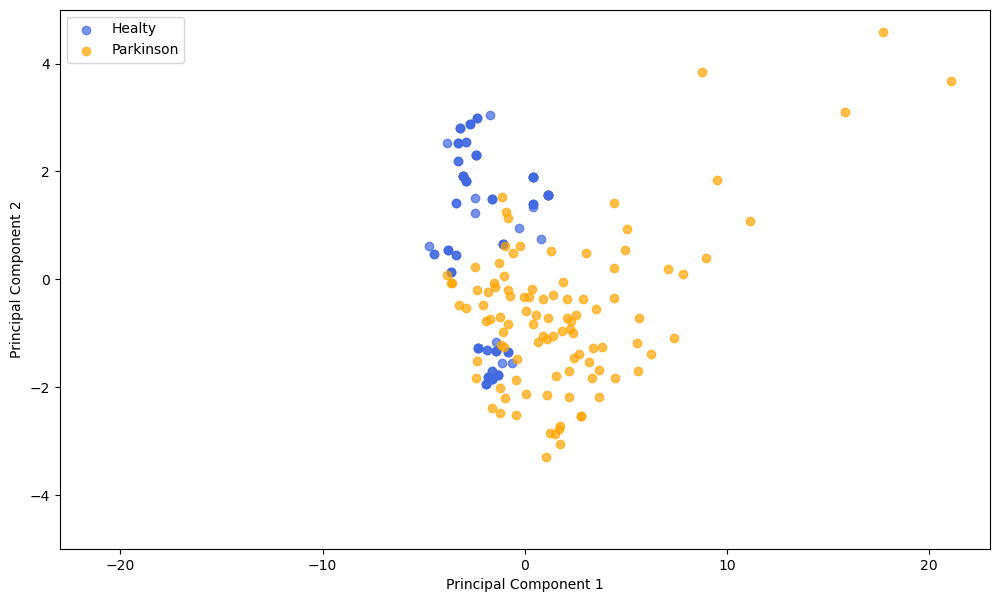

In [106]:
plot_data(X_train, y_train)

[0.60112644 0.11190257]


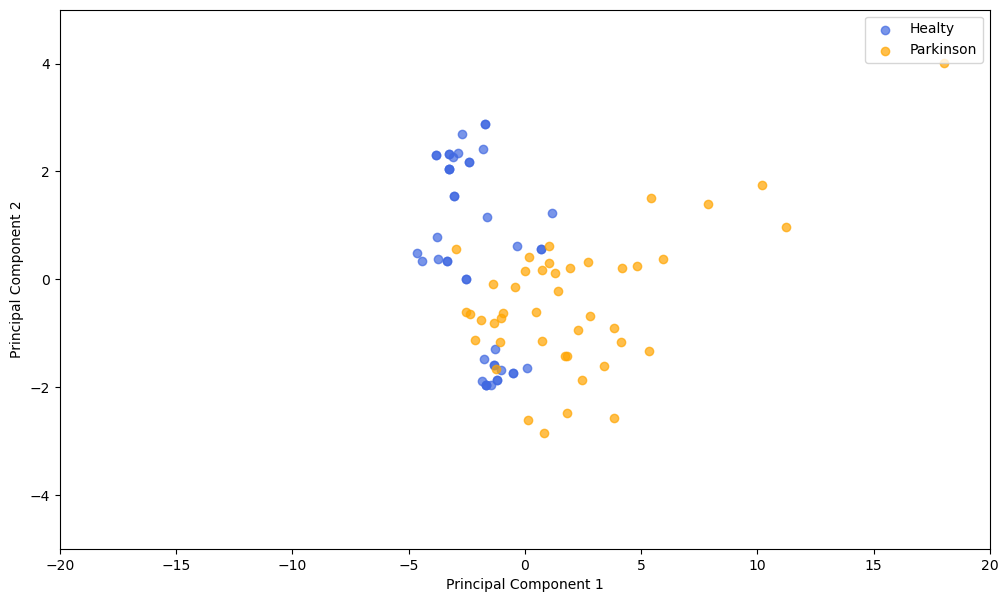

In [107]:
plot_data(X_test, y_test)

## Hard Margin SVM

In [108]:
linear_clf = SVC(kernel="linear")
linear_clf.fit(X_train, y_train)

test_score = linear_clf.score(X_test, y_test)

print("----- Linear SVM -----")
print(f"score on testing set: {test_score}")

----- Linear SVM -----
score on testing set: 0.7528089887640449


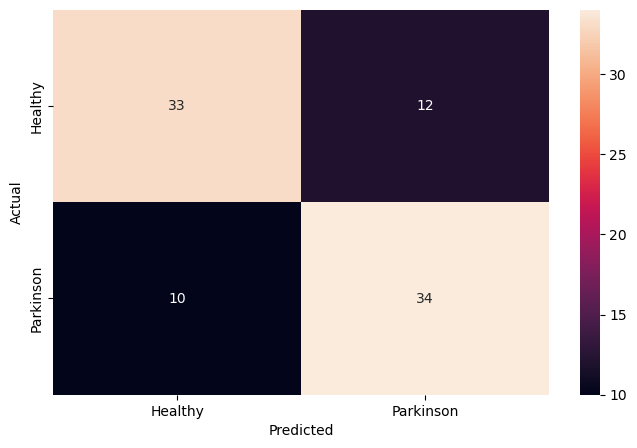

In [116]:
y_pred_sm = linear_clf.predict(X_test)
plot_cm(y_pred=y_pred_sm, y_true=y_test)

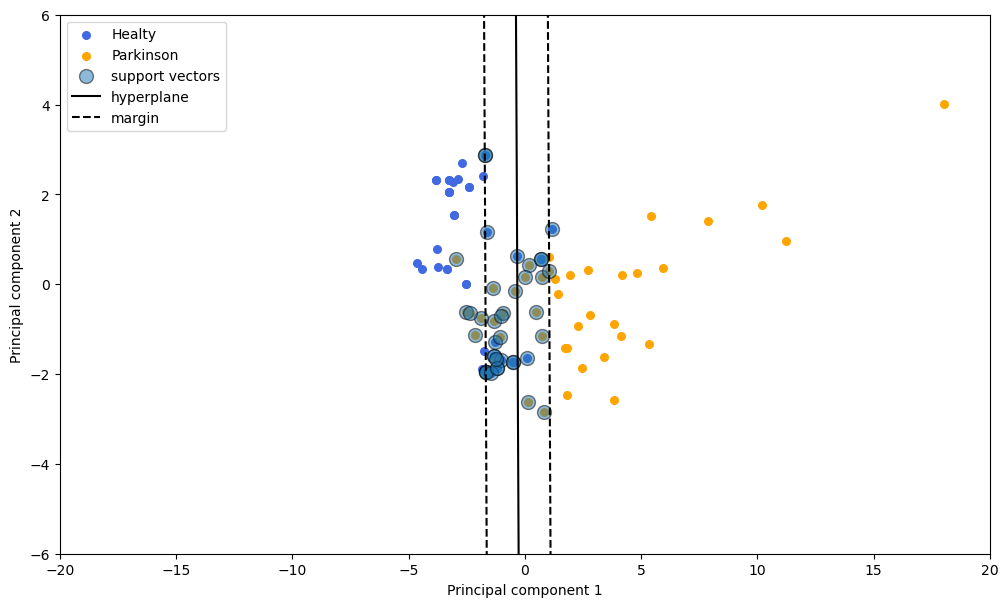

In [120]:
linear_clf.fit(X_test_pca, y_test)
plot_margins(X_test_pca, y_test, linear_clf.support_vectors_, linear_clf)

## Soft Margin SVM

In [138]:
soft_margin_params = {
	"C": [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2, 1.4, 1.6, 1.8]
}

gs_soft = GridSearchCV(
	estimator=SVC(kernel="linear"), 
	param_grid=soft_margin_params,
	cv=kf,
	refit=True,
	return_train_score=True
)

gs_soft.fit(X_train, y_train)
val_score = np.round(gs_soft.best_score_, 3)
test_score = np.round(gs_soft.score(X_test, y_test), 3)

print("----- Linear SVM with C Penalty -----")
print(f"score on validation set: {val_score}")
print(f"score on testing set: {test_score}")
print(f"best params: {gs_soft.best_params_}")

----- Linear SVM with C Penalty -----
score on validation set: 0.829
score on testing set: 0.753
best params: {'C': 0.9}


#### Predictions on testing set

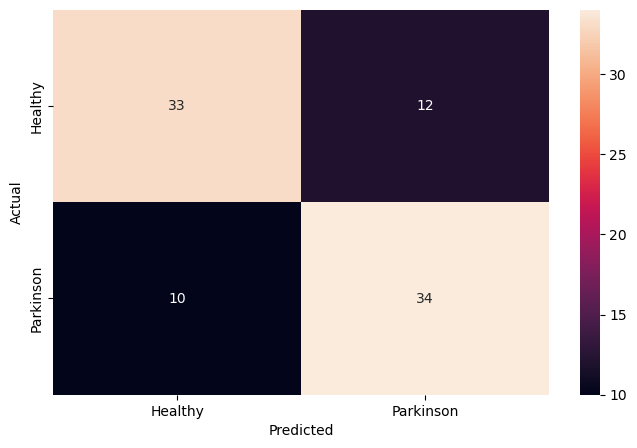

In [170]:
y_pred_hm = gs_soft.predict(X_test)

plot_cm(y_pred=y_pred_hm, y_true=y_test)

#### Plot of the decision region for the 2 principal components

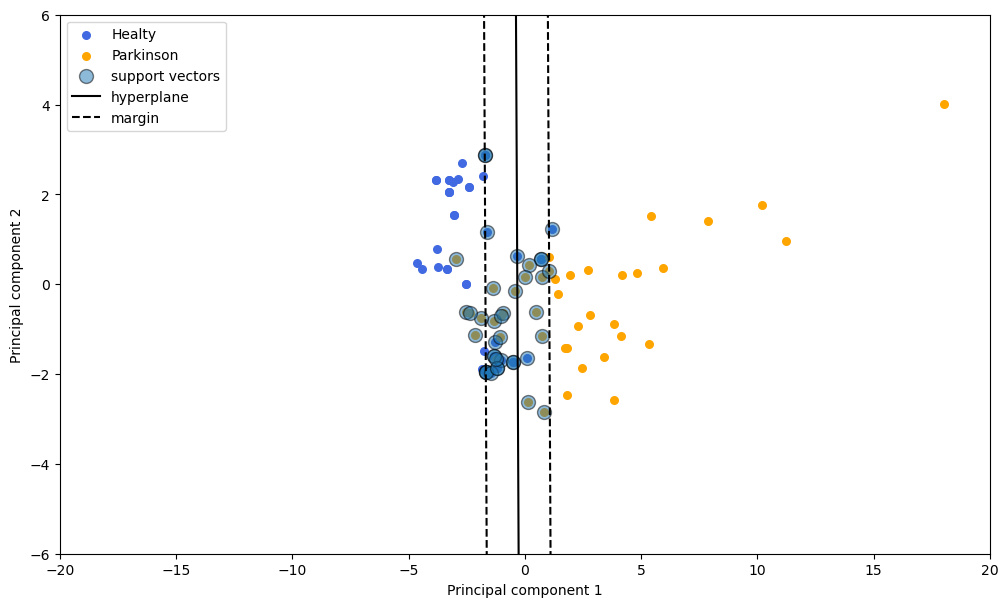

In [140]:
svm_sm = SVC(kernel="linear", C=gs_soft.best_params_["C"])
clf_sm = svm_sm.fit(X_test_pca, y_test)

plot_margins(X_test_pca, y_test, svm_sm.support_vectors_, clf_sm)

## Kernel Trick

In [149]:
kernel_params = {
	"C": [4.5, 4.51, 4.52, 4.53, 4.54, 4.55, 4.6, 4.65, 4.7, 4.75, 4.8, 5.0],
	"gamma": [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.005, 0.007, 0.01, 0.02, 0.1]
}

gs_kernel = GridSearchCV(
	estimator=SVC(kernel="rbf"), 
	param_grid=kernel_params,
	cv=kf,
	refit=True,
	return_train_score=True
)

gs_kernel.fit(X_train, y_train)
val_score = np.round(gs_kernel.best_score_, 3)
test_score = np.round(gs_kernel.score(X_test, y_test), 3)

print("----- SVM with Kernel Trick -----")
print(f"score on validation set: {val_score}")
print(f"score on testing set: {test_score}")
print(f"best params: {gs_kernel.best_params_}")

----- SVM with Kernel Trick -----
score on validation set: 0.961
score on testing set: 0.888
best params: {'C': 4.51, 'gamma': 0.005}


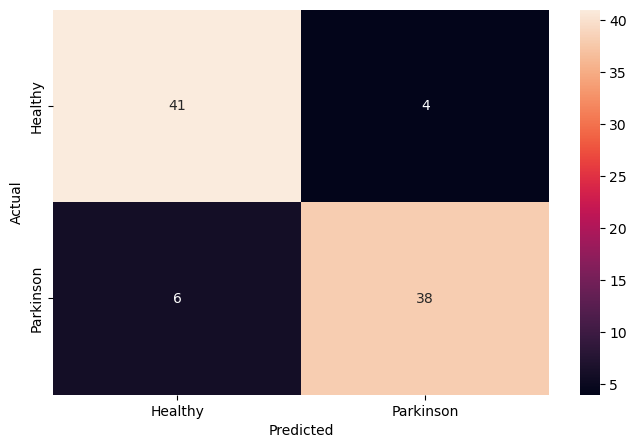

In [169]:
y_pred_kernel = gs_kernel.predict(X_test)

plot_cm(y_pred=y_pred_kernel, y_true=y_test)

Let's try our svm model on the testing set and plot the results on the 2 first principal components.

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1438/3878614929.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


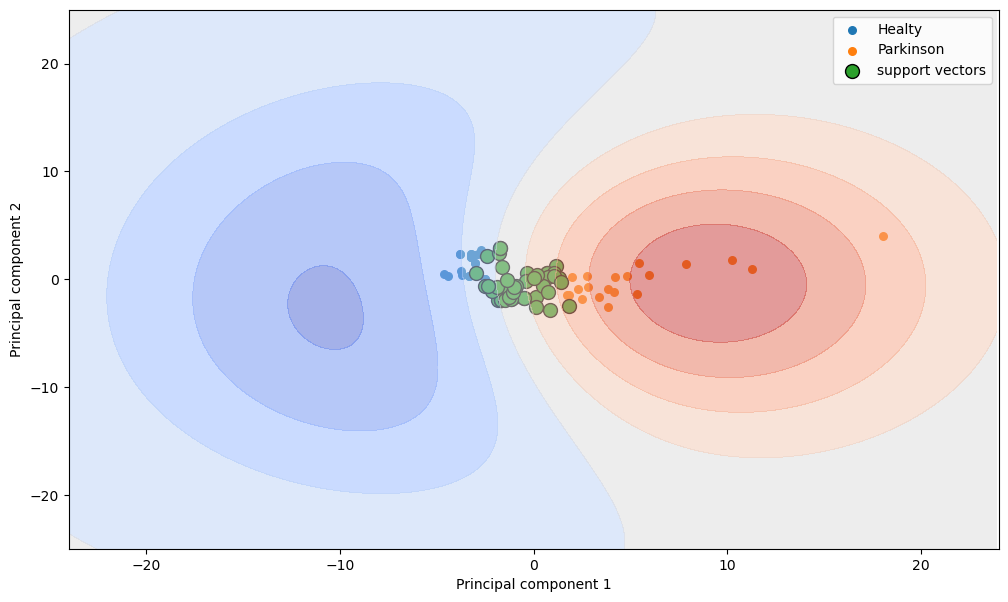

In [168]:
svm_kernel = SVC(kernel="rbf", C=gs_kernel.best_params_["C"], gamma=gs_kernel.best_params_["gamma"])
clf_kernel = svm_kernel.fit(X_test_pca, y_test)

plot_decision_regions(X_test_pca, y_test, svm_kernel.support_vectors_, clf_kernel, cmap="coolwarm")

In [62]:
custom_svm = SVM_SGA(kernel="rbf", C=gs_kernel.best_params_["C"], gamma=gs_kernel.best_params_["gamma"])
custom_svm.fit(X_test_pca, y_test)

converged at loop 181


In [63]:
svm_kernel.support_vectors_.shape

(46, 2)

In [64]:
custom_svm.support_vectors.shape

(47, 2)

## Tests

----- SVM with Kernel Trick -----
score on validation set: 0.958
score on testing set: 0.937
best params: {'SupVM__C': 100, 'SupVM__gamma': 0.05, 'pca__n_components': 2}


<Axes: >

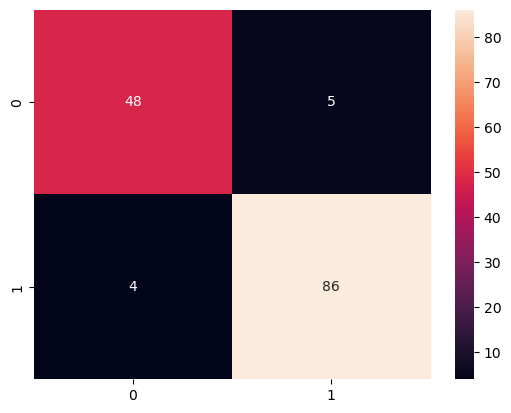

In [72]:
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline

kf = StratifiedKFold(n_splits=5)

cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.25, stratify=cancer.target, random_state=42)

# Pipeline Steps are StandardScaler, PCA and SVM 
pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('SupVM', SVC(kernel='rbf'))]

check_params= {
    'pca__n_components': [2], 
    'SupVM__C': [0.1, 0.5, 1, 10,30, 40, 50, 75, 100, 500, 1000], 
    'SupVM__gamma' : [0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline(pipe_steps)

create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=kf)
create_grid.fit(X_train, Y_train)

val_score = np.round(create_grid.best_score_, 3)
test_score = np.round(create_grid.score(X_test, Y_test), 3)

print("----- SVM with Kernel Trick -----")
print(f"score on validation set: {val_score}")
print(f"score on testing set: {test_score}")
print(f"best params: {create_grid.best_params_}")

Y_pred = create_grid.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True)

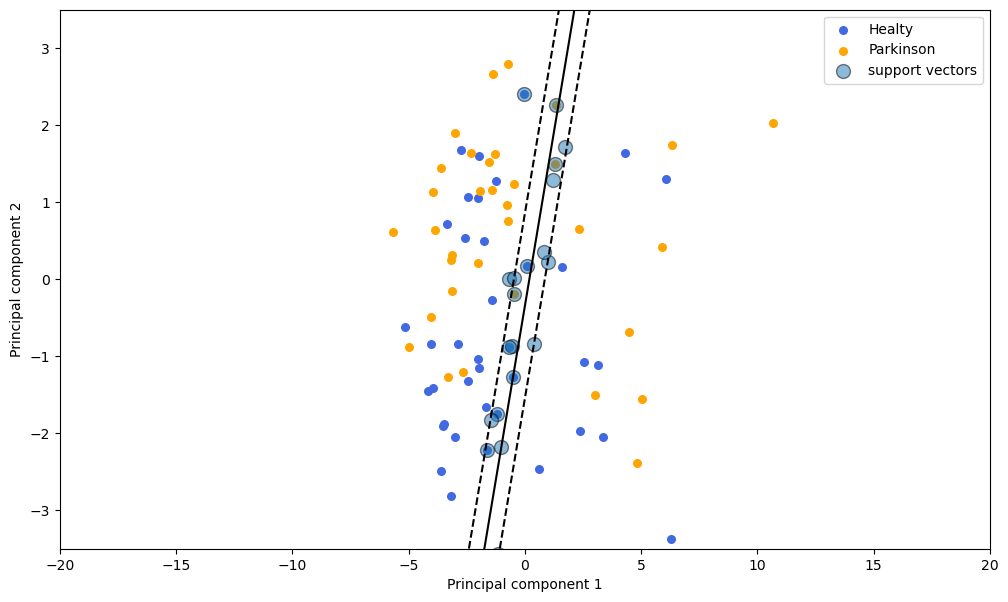

In [82]:
scaler = StandardScaler()
pca = PCA(n_components=2)

X_test_scaled = scaler.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)

svm = SVC(kernel="rbf", C=1., gamma=0.5)
clf = svm.fit(X_test_pca, Y_test)

svm.support_vectors_

svm_linear = SVC(kernel="linear")
clf_linear = svm_linear.fit(X_test_pca, Y_test)

plot_margins(X_test_pca, y_test, clf_linear.support_vectors_, clf_linear)

In [74]:
custom_svm = SVM_SGA(kernel="rbf", C=create_grid.best_params_["SupVM__C"], gamma=create_grid.best_params_["SupVM__gamma"])
custom_svm.fit(X_test_pca, Y_test)
custom_svm.support_vectors

converged at loop 1741


array([[-6.60280580e-01, -8.83848279e-01],
       [-4.92812364e-01, -1.27532301e+00],
       [ 1.05201457e-01,  1.65698571e-01],
       [ 1.93796352e+00,  5.10620723e+00],
       [-1.38167891e+00,  2.66660069e+00],
       [-1.12142596e+00,  4.64235163e+00],
       [ 1.33342002e+00,  2.26595424e+00],
       [-1.18082598e+00, -1.75615209e+00],
       [-1.14157873e+00, -3.57034358e+00],
       [-4.21053598e-02,  2.40485171e+00],
       [ 1.36415302e+01,  3.58642916e+00],
       [-4.71633735e-01, -1.95785419e-01],
       [ 1.57899132e+01, -7.03462152e+00],
       [ 1.32068235e+00,  1.50232080e+00],
       [-1.02049412e+00, -2.17715929e+00],
       [-5.48220852e-01, -8.63621546e-01],
       [ 1.72377162e+00,  1.71879915e+00],
       [-3.30408197e+00,  2.22336223e+00],
       [ 9.04823767e+00, -5.62572302e+00],
       [ 9.83644682e-01,  2.22870181e-01],
       [ 1.20700434e+00,  1.28850841e+00],
       [-4.58707085e-01,  1.54474789e-02],
       [ 8.08937866e-01,  3.55173378e-01],
       [ 3.

initial decision function shape;  (41360,)
after reshape:  (176, 235)


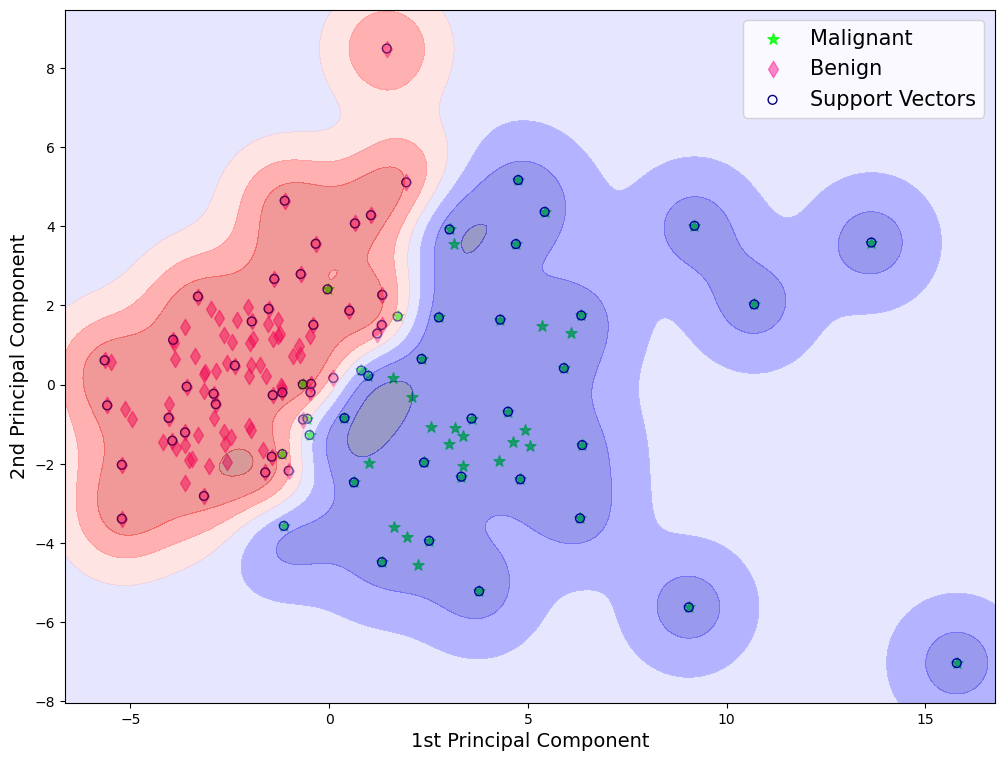

In [79]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    print ('initial decision function shape; ', np.shape(Z))
    Z = Z.reshape(xx.shape)
    print ('after reshape: ', np.shape(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.1):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))#,
                         #np.arange(z_min, z_max, h))
    return xx, yy

X0, X1 = X_test_pca[:, 0], X_test_pca[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_facecolor('white')
cdict1={0:'lime',1:'deeppink'}

Y_tar_list = Y_test.tolist()
yl1= [int(target1) for target1 in Y_tar_list]
labels1=yl1
 
labl1={0:'Malignant',1:'Benign'}
marker1={0:'*',1:'d'}
alpha1={0:.8, 1:0.5}

for l1 in np.unique(labels1):
    ix1=np.where(labels1==l1)
    ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=70,marker=marker1[l1],alpha=alpha1[l1])

ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=40, facecolors='none', 
           edgecolors='navy', label='Support Vectors')

plot_contours(ax, clf, xx, yy,cmap='seismic', alpha=0.4)
plt.legend(fontsize=15)

plt.xlabel("1st Principal Component",fontsize=14)
plt.ylabel("2nd Principal Component",fontsize=14)

#plt.savefig('ClassifyMalignant_Benign2D_Decs_FunctG10.png', dpi=300)
plt.show()


/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1438/2545031661.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


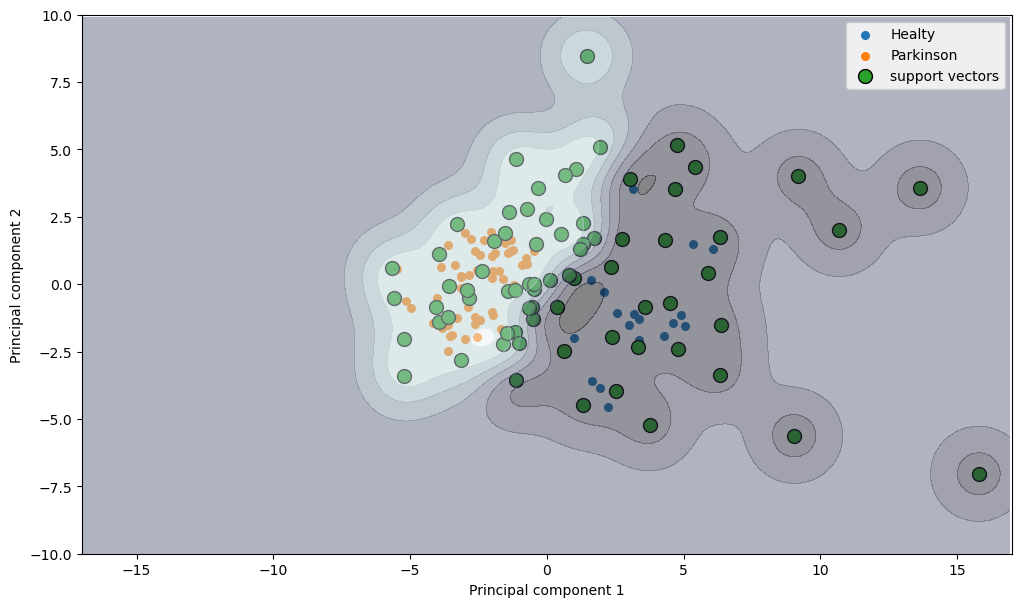

In [78]:
plot_decision_regions(X_test_pca, Y_test, svm.support_vectors_, clf)